In [1]:
# Import the needed packages

import os
import copy
import warnings

import numpy as np
import healpy as hp
import skyproj
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from astropy.time import Time, TimeDelta

from rubin_scheduler.scheduler.utils import generate_all_sky, Footprint

from rubin_scheduler.scheduler import sim_runner

from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.schedulers import SimpleBandSched, CoreScheduler
import rubin_scheduler.scheduler.example as ex
from rubin_scheduler.scheduler.surveys import FieldSurvey
import rubin_scheduler.scheduler.basis_functions as basis_functions
import rubin_scheduler.scheduler.detailers as detailers

from rubin_scheduler.scheduler.utils import SchemaConverter, run_info_table
import rubin_sim.maf.plots as plots
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metric_bundles as mb
from rubin_sim.maf.db import ResultsDb

# If running on the USDF, find rubin_scheduler data here:
if "usdf" in os.getenv("EXTERNAL_INSTANCE_URL", ""):
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# Helpful setup for notebook dev
import sv_support as sv

In [2]:
run_name = 'sv_ddf_3'
out_dir = run_name

In [3]:
# When might we start and end the survey?
# What would the actual time on-sky look like? 
# (start on dayobs rollover, so T12:00:00)
survey_start = Time('2025-06-11T12:00:00', format='isot', scale='utc')
survey_end = Time('2025-08-30T12:00:00', format='isot', scale='utc')

nside = 32

survey_info = sv.survey_times(survey_start, survey_end, verbose=True)

Survey start 2025-06-11 12:00:00.000
Survey end 2025-08-30T12:00:00.000
for a survey length of (nights) 80
Max length of night 11.929420676082373 min length of night 10.830742746591568
Total nighttime 926.3630492314696, total downtime 415.6710550838616, available time 510.69199414760806


south area 1175.0111032956336 south approx n fields 159.11608690461708
north area 651.2918686838655 south approx n fields 88.19577388427346
total area 1826.302971979499 total approx n fields 247.31186078889056
approx blob fields 49.5
closest approach to ecliptic in south area (deg)? -53.97543841632944
max/min elevation in south? 9.983784728061089 28.675375352803158
max/min elevation in north? 25.46420815280084 35.02459184719916
DDF radius 5.641895835477563 DD area, not including dither edges 100.71523742534 very approximate n fields 15.736755847709379
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes

wide goal visits per filter per point [0, 60, 60, 60, 60, 0]
deep goal visits per filter per point [64, 74, 184, 184, 166, 166]
deep visits per day, 30 day survey [2.13333333 2.46666667 6.13333333 6.13333333 5.53333333 5.53333333] 27.933333333333334
deep via sequence? approx ave nvis in sequence 111.0 approx time (min) of sequence 53.65


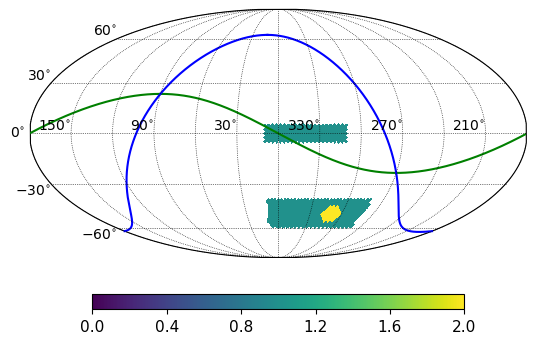

In [4]:
# Define footprint
survey_info = sv.survey_footprint(survey_info, nside=nside, verbose=True)

In [5]:
keys = ['wide_hp', 'deep_hp', 'combined_hp', 'deep']
survey_info['deep']

{'ra': 310, 'dec': -50, 'radius': np.float64(5.641895835477563)}

In [6]:
## SETUP SURVEY

# Pull up a pretty standard set of masks and a simple pair survey

standard_masks = ex.standard_masks(nside=nside, moon_distance=30, wind_speed_maximum=40)

camera_rot_limits = [-80, 80]

# And set up some simple pairs surveys .. probably will need modification
# (also this is slow because the simple_pairs_survey is redoing some of the work already done above ..hmm)
standard_pairs = [['u', 'g'], ['u', 'r'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['z', 'y'], ['y', 'y']]
sv_pairs = [['u', 'u'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['g', 'z'], ['y', 'y']]
pair_surveys = {}
for b1, b2 in sv_pairs:
    pair_surveys[f"{b1}{b2}"] = ex.simple_pairs_survey(nside=nside, bandname=b1, bandname2=b2, 
                                                 mask_basis_functions=standard_masks,
                                                 reward_basis_functions=None,
                                                 reward_basis_functions_weights=None,
                                                 footprints_hp=survey_info['combined_hp'],
                                                 survey_start=survey_info['survey_start'].mjd,
                                                 camera_rot_limits=camera_rot_limits,
                                                 pair_time=33, 
                                                 exptime=30, 
                                                 nexp=1, 
                                                 science_program='BLOCK-P')

# We'll maybe need greedy surveys to fill short periods of time
greedy_surveys = {}
for b in 'ugrizy':
    greedy_surveys[b] = ex.simple_greedy_survey(nside=nside, 
                                                bandname=b,
                                                mask_basis_functions=standard_masks,
                                                reward_basis_functions=None,
                                                reward_basis_functions_weights=None,
                                                survey_start=survey_info['survey_start'].mjd, 
                                                footprints_hp=survey_info['combined_hp'],
                                                camera_rot_limits=camera_rot_limits,
                                                exptime=30,
                                                nexp=1,
                                                science_program='BLOCK-G')


In [8]:
# DDF as field survey
# survey_lists = [[copy.deepcopy(dd_survey)], [copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]

# DDF as greedy survey
# survey_lists = [[copy.deepcopy(dd_surveys[k]) for k in dd_surveys] + [copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]

# DDF embedded in other footprint
survey_lists = [[copy.deepcopy(pair_surveys[k]) for k in pair_surveys], [copy.deepcopy(greedy_surveys[k]) for k in greedy_surveys]]


scheduler = CoreScheduler(survey_lists, nside, camera='LSST', telescope='rubin', band_to_filter={'u': 'u', 'g': 'g', 'r': 'r', 'i': 'i', 'z': 'z', 'y': 'y'})
scheduler.survey_lists

[[<BlobSurvey survey_name='simple pair 33, uu' at 0x166df1bd0>,
  <BlobSurvey survey_name='simple pair 33, gr' at 0x166df0190>,
  <BlobSurvey survey_name='simple pair 33, ri' at 0x166df1d10>,
  <BlobSurvey survey_name='simple pair 33, iz' at 0x166df1f90>,
  <BlobSurvey survey_name='simple pair 33, gz' at 0x166df0050>,
  <BlobSurvey survey_name='simple pair 33, yy' at 0x166df20d0>],
 [<GreedySurvey survey_name='simple greedy u' at 0x166df1e50>,
  <GreedySurvey survey_name='simple greedy g' at 0x166df2210>,
  <GreedySurvey survey_name='simple greedy r' at 0x166df2350>,
  <GreedySurvey survey_name='simple greedy i' at 0x166df2490>,
  <GreedySurvey survey_name='simple greedy z' at 0x166df25d0>,
  <GreedySurvey survey_name='simple greedy y' at 0x166df2710>]]

In [9]:
# What does the observatory look like?  (remember to set this back up if you change the downtimes)
setup_observatory = False
try:
    model_obs
except:
    setup_observatory = True 
    
if setup_observatory:
    model_obs = sv.setup_observatory(survey_info)

observatory = copy.deepcopy(model_obs)

# Filter scheduler - simply changes between ugriz and grizy depending on lunar phase
fs = SimpleBandSched(illum_limit=40)

In [10]:
%%capture sched_log
# Catch the RuntimeWarning if calc_reward returns all nans
rewards = True
scheduler.keep_rewards=rewards

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    vals = sim_runner(
        observatory,
        scheduler,
        band_scheduler=fs,
        sim_start_mjd=survey_info['survey_start'].mjd,
        sim_duration=survey_info['survey_length'],
        record_rewards=rewards,
        verbose=True,
    )
observatory = vals[0]
scheduler = vals[1]
observations = vals[2]
if len(vals) == 5:
    rewards = vals[3]
    obs_rewards = vals[4]

In [11]:
#sched_log.stderr

In [12]:
# If more debugging at a particular time is desired

# nside, scheduler = get_scheduler()
# observatory = get_ideal_model_observatory(nside=nside, dayobs = day_obs, wind_speed=0, wind_direction=0)
# observatory.observatory.setup_camera(band_changetime=5.0, maxspeed=1.5, shutter_2motion_min_time=0.0)
# observatory.observatory.setup_telescope(altitude_maxspeed=1.5, azimuth_maxspeed=1.5, settle_time=40.0)
# observatory.observatory.setup_dome(azimuth_maxspeed=3.0)
# observatory.mjd = sunset.mjd

# conditions = observatory.return_conditions()

# test_observations = []
# scheduler.update_conditions(conditions)
# obs = scheduler.request_observation(mjd=observatory.mjd, whole_queue=True)
# if obs is not None:
#     for o in obs:
#         observation, new_night = observatory.observe(o)
#         if observation is not None:
#             scheduler.add_observation(observation)
#             test_observations += [observation]

# Or look at survey basis functions at a particular time
# conditions = observatory.return_conditions()
# for ti, tier in enumerate(scheduler.survey_lists):
#     print(f"TIER {ti}")
#     for survey in tier:
#         print(survey.survey_name)
#         for bf in survey.basis_functions:
#             bf_values = bf(conditions)
#             if isinstance(bf_values, float) or isinstance(bf_values, int):
#                 print(bf.label(), bf.check_feasibility(conditions), bf_values)
#             else:
#                 print(bf.label(), bf.check_feasibility(conditions), np.nanmax(bf_values[survey.roi_hpid]))
#         print('total survey reward', np.nanmax(survey.calc_reward_function(conditions)))

Total night time (hours): 926.36
Total down time (hours): 415.67
Total available time (hours): 510.69
Total time in observations + slew (hours): 509.62
Unscheduled time (hours): 1.07


Text(0.5, 1.0, 'SV surveys from 2025-06-11 to 2025-08-30')

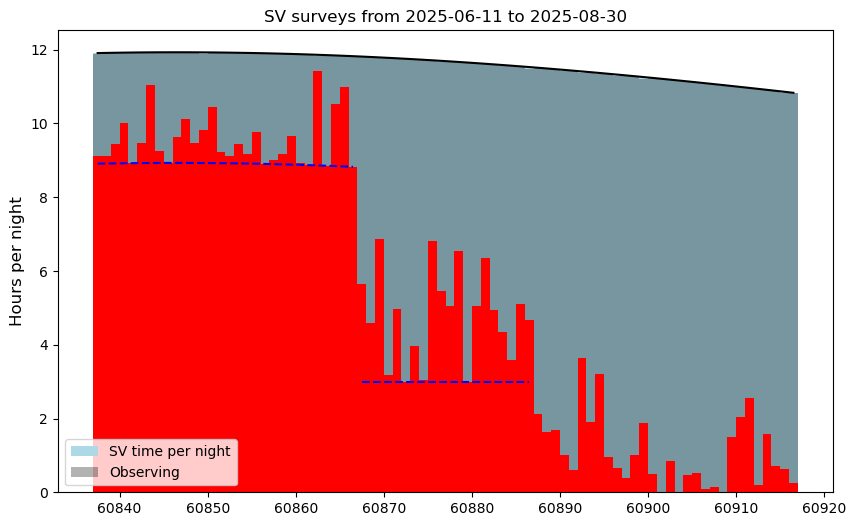

In [13]:
# Did we manage to schedule the available time? 

survey_info = sv.count_obstime(observations, survey_info)

plt.figure(figsize=(10,6))
plt.plot(survey_info['dayobsmjd'], survey_info['hours_in_night'], 'k')
w = 1
plt.bar(survey_info['dayobsmjd'], survey_info['downtime_per_night'], width=w, color='r')
plt.bar(survey_info['dayobsmjd'], survey_info['hours_in_night'] - survey_info['downtime_per_night'], bottom=survey_info['downtime_per_night'], width=w,
        color='lightblue', label="SV time per night")
plt.plot(survey_info['dayobsmjd'][0:survey_info['step1']], survey_info['hours_in_night'][0:survey_info['step1']] - 3, 'b--')
plt.plot(survey_info['dayobsmjd'][survey_info['step1']:survey_info['step2']], np.ones(survey_info['step2']-survey_info['step1']) * 3, 'b--')

plt.bar(survey_info['dayobsmjd'], survey_info['obs_time_per_night'],  bottom=survey_info['downtime_per_night'], 
        color='k', width=w, alpha=0.3, label='Observing')

plt.legend()
plt.ylabel("Hours per night", fontsize='large')
plt.title(f"SV surveys from {survey_start.iso[0:10]} to {survey_end.iso[0:10]}")

In [ ]:
plt.plot(survey_info['dayobsmjd'], (survey_info['hours_in_night'] - survey_info['downtime_per_night'] - survey_info['obs_time_per_night']) * 60)
plt.ylabel("Minutes missing per night")

In [ ]:
## SAVE OPSIM

sv.save_opsim(filename=os.path.join(out_dir, run_name + '.db'), observatory, observations)

visits = converter.obs2opsim(observations)
visitsdf = pd.DataFrame(visits)

results_db = ResultsDb(out_dir=out_dir)

In [ ]:
# BASIC METRICS

m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
s = slicers.HealpixSlicer(64)
constraint = ''
plot_dict = {'color_min': 0, 'color_max': 400}
bundle = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict, run_name=run_name)
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())
bundle.plot()

In [ ]:
bundles = {}
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
s = slicers.HealpixSlicer(64)
for i, b in enumerate('griz'):
    constraint = b
    bundles[b] = mb.MetricBundle(m, s, constraint, run_name=run_name)
    g = mb.MetricBundleGroup({0: bundles[b]}, None, out_dir=out_dir)
    g.run_current(constraint, sim_data=visitsdf.query("band.str.contains(@b)").to_records())
    print(b, 'max nvisits', bundles[b].metric_values.compressed().max(), 'median', np.median(bundles[b].metric_values.compressed()))
    bundles[b].plot()

In [ ]:
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
hpixnside= 256
s, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)
constraint = ''
bundle = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict, run_name=run_name)
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())

print("Area with more than 800 visits", len(np.where(bundle.metric_values.compressed() > 800)[0]) * hp.nside2pixarea(hpixnside, degrees=True))
print("Area with more than 400 visits", len(np.where(bundle.metric_values.compressed() > 400)[0]) * hp.nside2pixarea(hpixnside, degrees=True))
bundle.plot()

In [ ]:
bundles = {}
m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
hpixnside= 256
s, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)
for i, b in enumerate('ugrizy'):
    constraint = b
    bundles[b] = mb.MetricBundle(m, s, constraint, plot_dict=plot_dict, run_name=run_name)
    g = mb.MetricBundleGroup({0: bundles[b]}, None, out_dir=out_dir)
    sim_data = visitsdf.query("band.str.contains(@b)").to_records()
    if len(sim_data) > 0:
        g.run_current(constraint, sim_data=visitsdf.query("band.str.contains(@b)").to_records())
    if bundles[b].metric_values is not None:
        print(b, 'max nvisits', bundles[b].metric_values.compressed().max(), 'median', np.median(bundles[b].metric_values.compressed()),  'ratio', bundles[b].metric_values.compressed().max()/dd_goals[i])
    else:
        print(f"No metric values calculated for band {b}")
    bundles[b].plot()

In [ ]:
print(visitsdf.scheduler_note.unique())
print(len(visitsdf), len(visitsdf.query('target_name.str.contains("DD")')))

In [ ]:
nights = visitsdf.query('target_name.str.contains("DD")').groupby('night').count()['observationStartMJD']
plt.bar(nights.index.values, nights.values, label='DDF visits')
plt.xlabel("Night")
plt.ylabel("Visits per night")
plt.legend()

In [ ]:
nights = visitsdf.query('target_name.str.contains("DD")').groupby('night').agg({'observationStartMJD': np.ptp})
plt.bar(nights.index.values, nights.observationStartMJD * 24, label='DDF sequence time (hours)')
plt.xlabel("Night")
plt.ylabel("Sequence time per night")
plt.legend()
plt.ylim(0, 1)

In [ ]:
bins = np.arange(0, 30, 1)
m = metrics.NVisitsPerNightMetric(bins=bins)
s = slicers.HealpixSlicer(nside=64)
constraint = ''
bundle = mb.MetricBundle(m, s, constraint, run_name=run_name, 
                         plot_funcs=[plots.SummaryHistogram()], plot_dict={'bins': bins})
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.to_records())
bundle.plot()

In [ ]:
bins = np.arange(0, 30, 1)
m = metrics.NVisitsPerNightMetric(bins=bins)
s = slicers.HealpixSlicer(nside=64)
constraint = 'griz'
bundle = mb.MetricBundle(m, s, constraint, run_name=run_name, 
                         plot_funcs=[plots.SummaryHistogram()], plot_dict={'bins': bins})
g = mb.MetricBundleGroup({0: bundle}, None, out_dir=out_dir)
g.run_current(constraint, sim_data=visitsdf.query("band!='y' and band!='u'").to_records())
bundle.plot()